# NDVI Anomaly
Notebook to generate NDVI anomaly, showing changes in NDVI between two time periods. To show actual change two time period of similar seasonality should be used. 
The output is an NDVI anomaly and also a threshold product, the thresholds assocaited with the product can be adjusted depending on what you changes the user is interested in. 

Adapted from https://github.com/ceos-seo/data_cube_notebooks for us in Satellite Applications Catapult Common Sensing DataCube

This notebook compares NDVI between two time periods to detect land change. In the case of deforestation, the NDVI values will reduce from (0.6 to 0.9 ... typical for forests) to lower values (<0.6). This change can be detected and used to investigate deforestation or monitor the extent of the land change.

In [1]:
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
# Set reference for util modules
import sys
sys.path.append('/home/jovyan/odc-hub/')
# Generic python
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr 

# Bonus vector manipulation
import pandas as pd
#from pandas import Dataframe
import geopandas as gpd
from shapely import wkt
from datetime import datetime
import datacube

from matplotlib.cm import RdYlGn, Greens

CMAP = "Blues"

In [2]:
#import datacube utilities
import utils_dcal.data_cube_utilities.data_access_api as dc_api  
from utils_dcal.data_cube_utilities.dc_load import get_product_extents
from utils_dcal.data_cube_utilities.dc_time import dt_to_str
from utils_dcal.data_cube_utilities.dc_display_map import display_map
from utils_dcal.data_cube_utilities.dc_mosaic import create_max_ndvi_mosaic, create_median_mosaic, create_mosaic
from utils_dcal.data_cube_utilities.dc_rgb import rgb
from utils_sac.createAOI import create_lat_lon
from utils_dcal.data_cube_utilities.dc_water_classifier import wofs_classify
from utils_sac.createindices import NDVI
from utils_sac.fromDCALscripts import threshold_plot
from utils_dcal.data_cube_utilities.dc_utilities import write_geotiff_from_xr
from utils_sac.clean_mask import landsat_qa_clean_mask


ModuleNotFoundError: No module named 'utils_sac.dc_mosaic_delete'

# NDVI Anomaly 
Adapted from https://github.com/ceos-seo/data_cube_notebooks for us in Satellite Applications Catapult Common Sensing DataCube

This notebook compares NDVI between two time periods to detect land change. In the case of deforestation, the NDVI values will reduce from (0.6 to 0.9 ... typical for forests) to lower values (<0.6). This change can be detected and used to investigate deforestation or monitor the extent of the land change.

# Choose Platform and Product

In [3]:
api = dc_api.DataAccessApi()
dc = datacube.Datacube(app='ndvi anomoly')

## Set Variables

In [4]:
#area of interest: load in as wkt
aoi_wkt = "POLYGON((178.98101806642 -17.592544555664, 179.03903961183 -17.593231201171, 179.03903961183 -17.66258239746, 178.97998809815 -17.661209106445, 178.98101806642 -17.592544555664))"
#set-project: This is the same for all of FIJI so this may not need to be a variable within the Fijian cube.
output_projection = "EPSG:32760"
#set resolution_if using Landsat min 30m, if sentinel min 10m 
res = (30)
#platform is the sensor, options include 'LANSAT_8', 'LANSAT_7', 'LANSAT_5', 'LANSAT_4', 'SENTINEL_2'
platform_base = 'LANDSAT_8'
platform_analysis = 'LANDSAT_8'

In [5]:
#set baseline start and end of period
baseline_start_date = '2015-3-1'
baseline_end_date = '2015-9-1'

#set the analysis start and end of period
analysis_start_date = '2016-3-1'
analysis_end_date = '2016-9-1'

# Select the cloud-free mosaic type
# Options are: max_ndvi, median, most_recent_pixel
mosaic_type = "median"

# Select a baseline NDVI threshold range
# The analysis will only consider pixels in this range for change detection
# Example: use 0.6 to 0.9 for dense vegetation
# grasslands are 0.2 to 0.6
# all vegetation 0.2 to 1
# these vary with area - the user should can adjust these to make most appropriate.
ndvi_baseline_threshold_range = (0.6, 1)  

In [6]:
# Select NDVI Anomaly Threshold Range
# We are looking for pixels that have lost significant vegetation
# NDVI losses are typically 0.1 or more for deforestation - this should be  varied depending on what the user is looking for.

minimum_change = -0.7
maximum_change = -0.2

### Create AOI

In [7]:
lat_extents, lon_extents = create_lat_lon(aoi_wkt)

In [8]:
## The code below renders a map that can be used to orient yourself with the region.
display_map(latitude = lat_extents, longitude = lon_extents)

## Translate inputs and load data

In [9]:
allmeasurements = ["green","red","blue","nir","swir1","swir2"]
def create_product_measurement(platform):
    if platform  in ["SENTINEL_2"]:
        product = 's2_esa_sr_granule'
        measurements = allmeasurements + ["coastal_aerosol","scene_classification"]
    elif platform_analysis in ["LANDSAT_8"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls8_usgs_sr_scene'
    elif platform_analysis in ["LANDSAT_7"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls7_usgs_sr_scene'
    elif platform_analysis in ["LANDSAT_5"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls5_usgs_sr_scene'
    elif platform_analysis in ["LANDSAT_4"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls4_usgs_sr_scene'
    else:
        print("invalid platform")
    return product, measurements 

In [10]:
baseline_product, baseline_measurement = create_product_measurement(platform_base)
analysis_product, analysis_measurement = create_product_measurement(platform_analysis)

In [11]:
#create resolution
resolution = (-res, res)

In [12]:
#format dates
def createDate(inputStart, inputEnd):
    start = datetime.strptime(inputStart, '%Y-%m-%d')
    end = datetime.strptime(inputEnd, '%Y-%m-%d')
    startDates = start.date()
    endDates = end.date()
    time_period = (startDates, endDates)
    return time_period

baseline_time_period = createDate(baseline_start_date, baseline_end_date)
analysis_time_period = createDate(analysis_start_date, analysis_end_date)

print(baseline_time_period)

(datetime.date(2015, 3, 1), datetime.date(2015, 9, 1))


### Import products from datacube 

In [13]:
# Create the 'query' dictionary object, which contains the longitudes, latitudes 
query = {
    'y': lat_extents,
    'x': lon_extents,
    'output_crs': output_projection,  
    'resolution': resolution
}

>#### Load Data ( Baseline, Analysis) 

In [14]:
baseline_ds = dc.load(
    time = baseline_time_period,
    platform = platform_base,
    product = baseline_product,
    measurements = baseline_measurement,
    **query
)


In [15]:
analysis_ds = dc.load(
    time = analysis_time_period,
    platform = platform_analysis,
    product = analysis_product,
    measurements = analysis_measurement,
    **query
)

### Check if loads are valid

In [16]:
def is_dataset_empty(ds:xr.Dataset) -> bool:
    checks_for_empty = [
                        lambda x: len(x.dims) == 0,      #Dataset has no dimensions
                        lambda x: len(x.data_vars) == 0  #Dataset no variables 
                       ]
    for f in checks_for_empty:
         if f(ds) == True:
                return True
    return False

In [17]:
if is_dataset_empty(baseline_ds): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Baseline Dataset!")

In [18]:
if is_dataset_empty(analysis_ds): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Analysis Dataset!")

#### Create CLoud Mask
Generating boolean masks that highlight valid pixels
Pixels must be cloud-free over land or water to be considered

In [19]:
#create cloud mask
baseline_clean_mask = landsat_qa_clean_mask(baseline_ds, platform_analysis)
analysis_clean_mask = landsat_qa_clean_mask(analysis_ds, platform_base)

In [20]:
baseline_ds = baseline_ds.where(baseline_clean_mask)
analysis_ds = analysis_ds.where(analysis_clean_mask)

### Perform Mosaic
 Use clean masks in a time series composite

In [21]:
#add in geomedian - get rid of others
mosaic_function = {"median": create_median_mosaic,
                   "max_ndvi": create_max_ndvi_mosaic,
                   "most_recent_pixel": create_mosaic}

In [22]:
new_compositor = mosaic_function[mosaic_type]


In [23]:
baseline_composite = new_compositor(baseline_ds, clean_mask = baseline_clean_mask)
analysis_composite = new_compositor(analysis_ds, clean_mask = analysis_clean_mask)

### Mask out Water

In [24]:
water_class_base = wofs_classify(baseline_composite, mosaic=True, x_coord='x', y_coord='y').wofs
baseline_composite = baseline_composite.copy(deep=True).where((baseline_composite != np.nan) & (water_class_base == 0))
water_class_analy = wofs_classify(analysis_composite, mosaic=True, x_coord='x', y_coord='y').wofs
analysis_composite = analysis_composite.copy(deep=True).where((analysis_composite != np.nan) & (water_class_analy == 0))

(<Figure size 720x587.586 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f57e0744748>)

<Figure size 432x216 with 0 Axes>

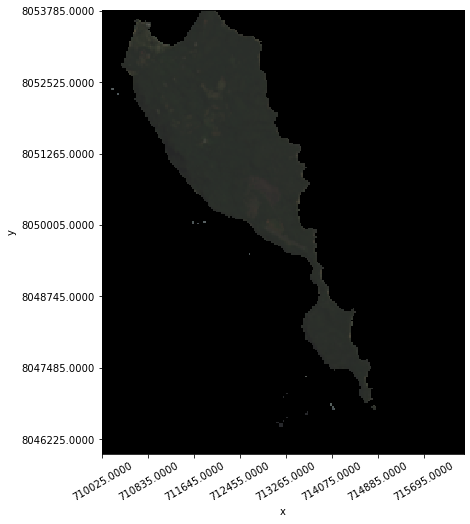

In [25]:
plt.figure(figsize = (6,3))
rgb(baseline_composite, x_coord='x', y_coord='y')

(<Figure size 720x587.586 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f57e07474e0>)

<Figure size 432x216 with 0 Axes>

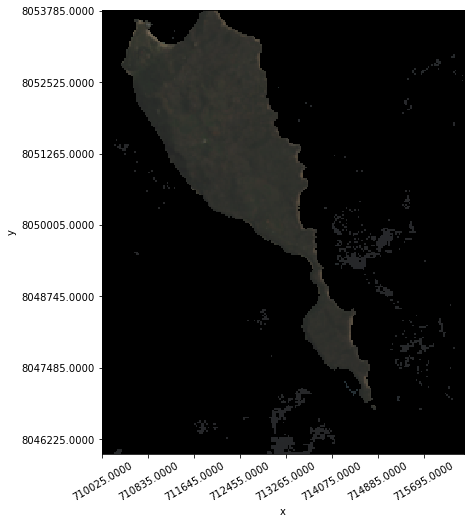

In [26]:
plt.figure(figsize = (6,3))
rgb(analysis_composite, x_coord='x', y_coord='y')

### Baseline Mosaic using the NDVI Threshold Range
To only include pixels within our interest threshold range

In [27]:
#reomve threshold.
_min, _max = ndvi_baseline_threshold_range  
baseline_ndvi_filter_mask = np.logical_and(NDVI(baseline_composite) > _min, NDVI(baseline_composite) < _max)    

In [28]:
def aspect_ratio_helper(ds, fixed_width = 15):
        y,x = ds.values.shape
        width = fixed_width
        height = y * (fixed_width / x)
        return (width, height)

In [29]:
RdYlGn.set_bad('black',1.)
Greens.set_bad('black',1.)

<Figure size 1080x1323.38 with 0 Axes>

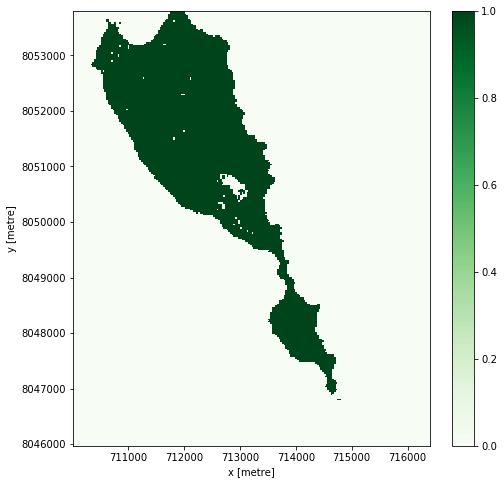

In [30]:
# This is the baseline NDVI threshold plot that shows GREEN pixels in the threshold range
plt.figure(figsize = aspect_ratio_helper(baseline_ndvi_filter_mask)) 
plt.figure(figsize = (8,8))
baseline_ndvi_filter_mask.plot(cmap = "Greens")

In [31]:
baseline_composite = baseline_composite.where(baseline_ndvi_filter_mask)

# NDVI Anomaly

In [32]:
#calculate NDVI
ndvi_baseline_composite = NDVI(baseline_composite)
ndvi_analysis_composite = NDVI(analysis_composite)

In [55]:
print(ndvi_baseline_composite)

<xarray.DataArray (y: 261, x: 213)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y        (y) float64 8.054e+06 8.054e+06 8.054e+06 ... 8.046e+06 8.046e+06
  * x        (x) float64 7.1e+05 7.101e+05 7.101e+05 ... 7.164e+05 7.164e+05


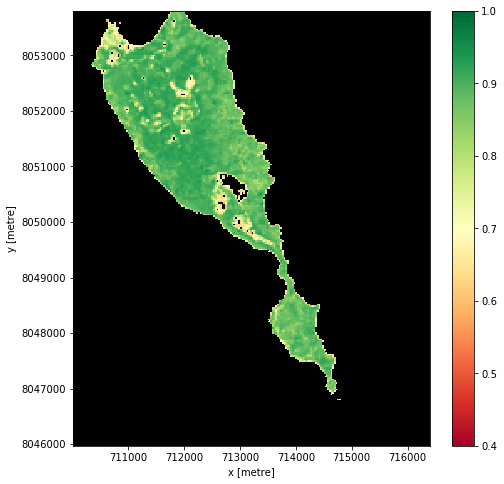

In [33]:
plt.figure(figsize = (8,8))
ndvi_baseline_composite.plot(vmin=0.4, vmax=1, cmap = RdYlGn)

In [34]:
print(ndvi_baseline_composite)

<xarray.DataArray (y: 261, x: 213)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y        (y) float64 8.054e+06 8.054e+06 8.054e+06 ... 8.046e+06 8.046e+06
  * x        (x) float64 7.1e+05 7.101e+05 7.101e+05 ... 7.164e+05 7.164e+05


In [35]:
#export
ndvi_baseline_export = xr.DataArray.to_dataset(ndvi_baseline_composite, dim = None, name = 'ndvi_baseline')
write_geotiff_from_xr('ndvi_baseline.tiff', ndvi_baseline_export, ["ndvi_baseline"], crs=output_projection, x_coord = 'x', y_coord = 'y')

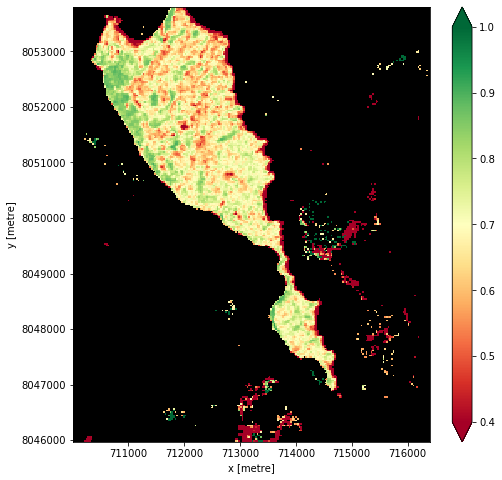

In [36]:
plt.figure(figsize = (8,8))
ndvi_analysis_composite.plot(vmin=0.4, vmax=1, cmap = RdYlGn)

In [37]:
#export
ndvi_analysis_export = xr.DataArray.to_dataset(ndvi_analysis_composite, dim = None, name = 'ndvi_analysis')
write_geotiff_from_xr('ndvi_analysis.tiff', ndvi_analysis_export, ["ndvi_analysis"], crs=output_projection, x_coord = 'x', y_coord = 'y')

In [38]:
#calculate ndvi anomaly
ndvi_anomaly = ndvi_analysis_composite - ndvi_baseline_composite

NDVI Anomaly Plot


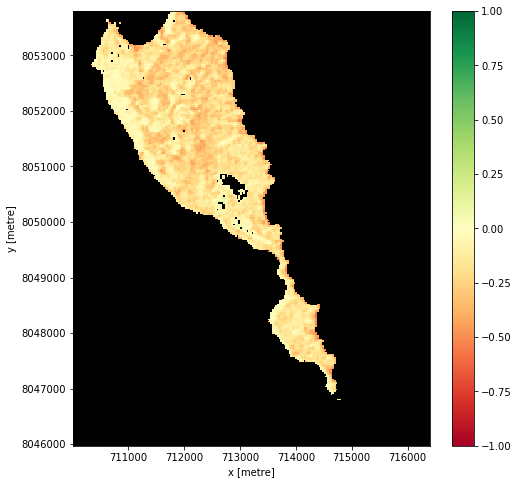

In [39]:
plt.figure(figsize = (8,8))
ndvi_anomaly.plot(vmin=-1, vmax=1, cmap = RdYlGn)

Discretized/Binned plot

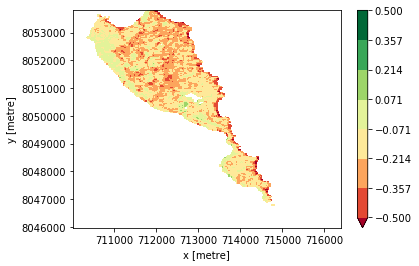

In [40]:
ndvi_anomaly.plot(levels = 8, vmin=-0.5, vmax=0.5, cmap = RdYlGn)

In [41]:
from utils_dcal.data_cube_utilities.plotter_utils import create_discrete_color_map
cmap = create_discrete_color_map(data_range=(-1,1), 
                                 th=[0.0], colors=[(240,93,94), (126,243,125)])
cmap.set_bad("black", 1.)

>#### NDVI Anomaly

This product shows the following ...<br>
BLACK = Cloud or Pixels NOT in the baseline threshold range<br>
GREEN = Pixels with an increase in NDVI<br>
RED = Pixels with a decrease in NDVI<br>

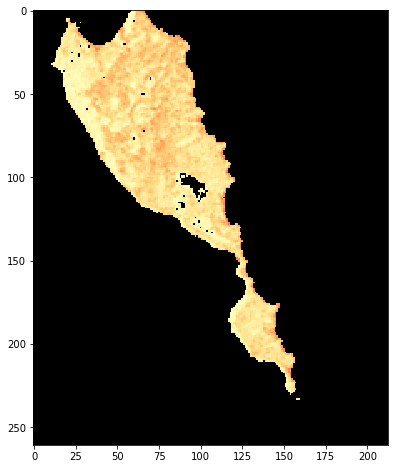

In [42]:
# plt.figure(figsize = aspect_ratio_helper(ndvi_anomaly)) 
plt.figure(figsize = (8,8))
plt.imshow(ndvi_anomaly.values, cmap=RdYlGn, vmin=-1, vmax=1)
plt.show()

In [43]:
#export
ndvi_anomaly_export = xr.DataArray.to_dataset(ndvi_anomaly, dim = None, name = 'ndvi_anomaly')
write_geotiff_from_xr('ndvi_anomaly.tiff', ndvi_anomaly_export, ["ndvi_anomaly"], crs=output_projection, x_coord = 'x', y_coord = 'y')

# NDVI Anomaly Threshold Product

>#### NDVI Change Distribution
Threshold range, highlighted in red

In [44]:
no_data_mask = np.logical_or(np.isnan(baseline_composite.red.values), np.isnan(analysis_composite.red.values)) 

In [45]:
if hasattr(ndvi_anomaly, 'x'):
    ndvi_anomaly = ndvi_anomaly.rename({"x":"longitude", "y":"latitude"})
else:
    print('latitude and longitude exist')

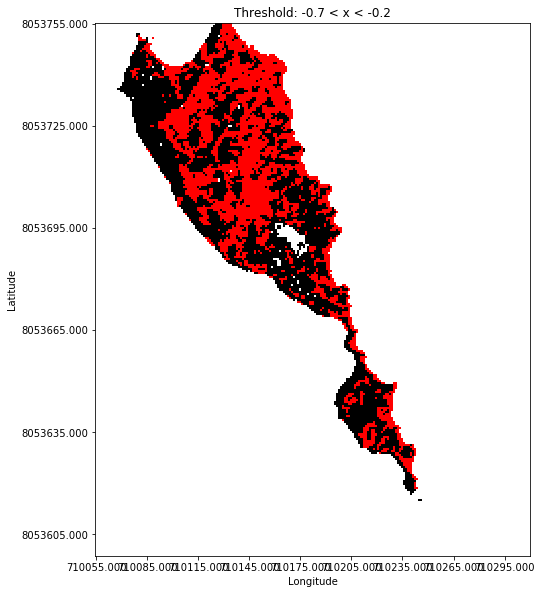

In [46]:
threshold_plot(ndvi_anomaly, minimum_change, maximum_change, mask = no_data_mask, width  = 8)

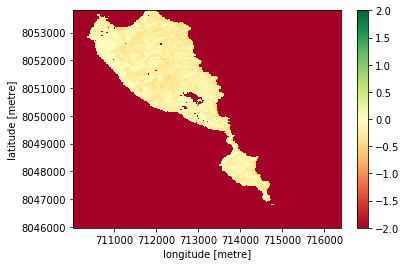

In [47]:
#mask no_data_values, and assign a valueof -2 to nodata
#commented this out check it #ndvi_threshold = ndvi_anomaly.where(ndvi_anomaly > minimum_change, ndvi_anomaly < maximum_change)
ndvi_anomaly_mask = np.ma.array(ndvi_anomaly, mask = no_data_mask)
ndvi_anomaly_a = (ndvi_anomaly).where(ndvi_anomaly_mask.mask == False)
thres_1 = xr.DataArray.fillna(ndvi_anomaly_a, -2)
thres_1.plot(cmap = "RdYlGn")

[[-2.0 -2.0 -2.0 ... -2.0 -2.0 -2.0]
 [-2.0 -2.0 -2.0 ... -2.0 -2.0 -2.0]
 [-2.0 -2.0 -2.0 ... -2.0 -2.0 -2.0]
 ...
 [-2.0 -2.0 -2.0 ... -2.0 -2.0 -2.0]
 [-2.0 -2.0 -2.0 ... -2.0 -2.0 -2.0]
 [-2.0 -2.0 -2.0 ... -2.0 -2.0 -2.0]]


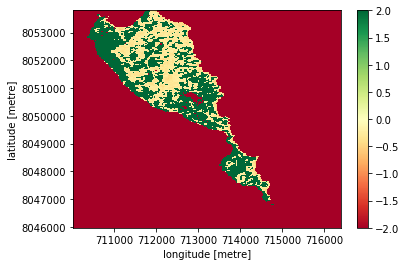

In [54]:
# apply maximumthreshold, to classify data abovethreshold.
a = thres_1
no_data_mask2 = np.logical_or(a > maximum_change, a == maximum_change)
ndvi_anomaly_mask2 = np.ma.array(a, mask = no_data_mask2)
print(ndvi_anomaly_mask2)
ndvi_anomaly3 = a.where(ndvi_anomaly_mask2.mask == False)
thres_2 = xr.DataArray.fillna(ndvi_anomaly3, 2)
thres_2.plot(cmap = "RdYlGn")

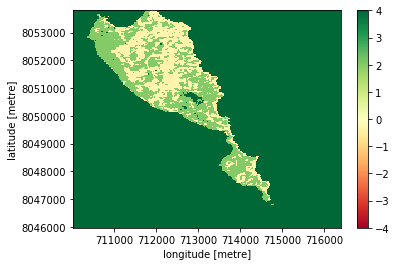

In [56]:
b = thres_2
no_data_mask3 = np.logical_or(b < -2, b == -2)
ndvi_anomaly_mask3 = np.ma.array(b, mask = no_data_mask3)
ndvi_anomaly4 = b.where(ndvi_anomaly_mask3.mask == False)
thres_3 = xr.DataArray.fillna(ndvi_anomaly4, 4)
thres_3.plot(cmap = "RdYlGn")

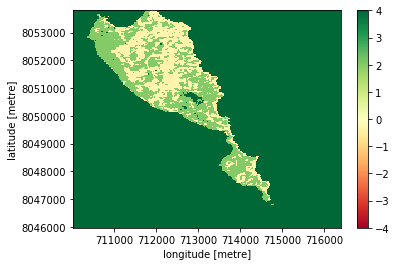

In [57]:
c = thres_3
no_data_mask4 = np.logical_or(c < minimum_change, c == minimum_change)
ndvi_anomaly_mask4 = np.ma.array(c, mask = no_data_mask4)
ndvi_anomaly5 = c.where(ndvi_anomaly_mask4.mask == False)
thres_4 = xr.DataArray.fillna(ndvi_anomaly5, 2)
thres_4.plot(cmap = "RdYlGn")

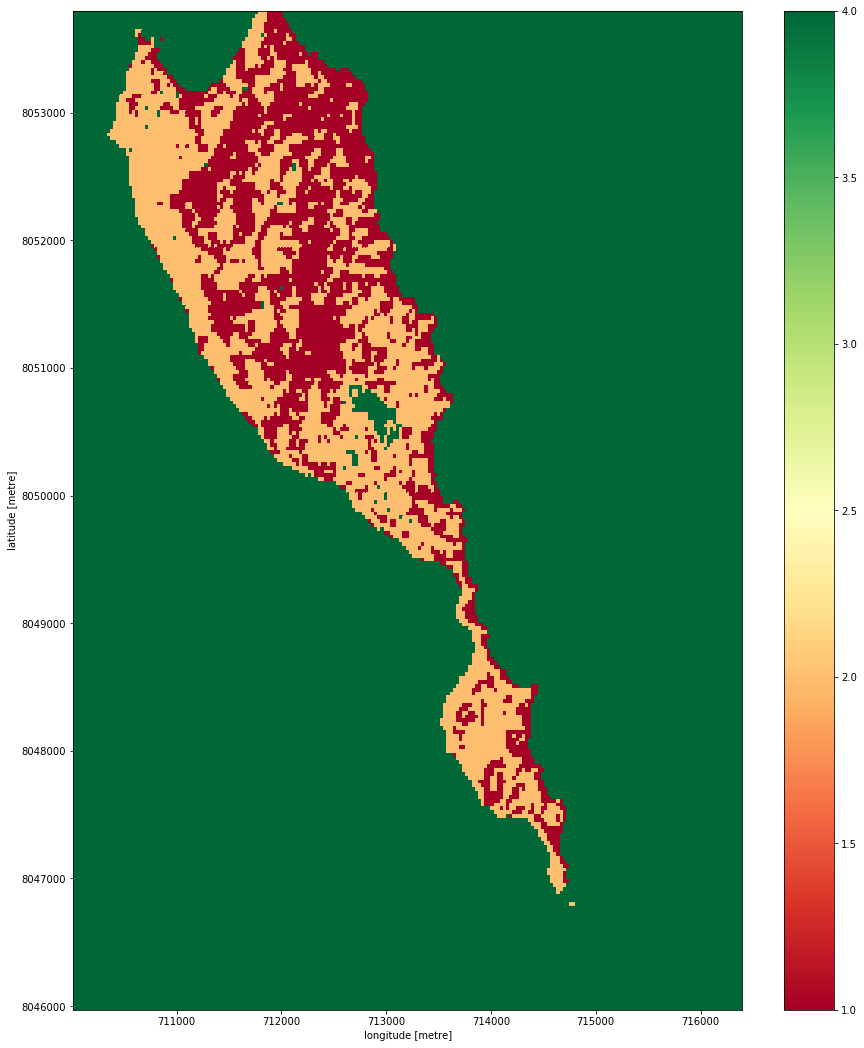

In [58]:
d = thres_4
no_data_mask5 = np.logical_and(d > minimum_change, d < maximum_change)
ndvi_anomaly_mask5 = np.ma.array(d, mask = no_data_mask5)
ndvi_anomaly6 = c.where(ndvi_anomaly_mask5.mask == False)
thres_5 = xr.DataArray.fillna(ndvi_anomaly6, 1)
plt.figure(figsize = aspect_ratio_helper(thres_5)) 
thres_5.plot(cmap = "RdYlGn")

In [52]:
output = xr.DataArray.to_dataset(thres_5, dim = None, name = 'ndvi_thres')

In [53]:

write_geotiff_from_xr('ndvi_thres.tiff', output, ["ndvi_thres"], crs=output_projection, x_coord = 'longitude', y_coord = 'latitude')